librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

import requests
import unidecode
import datetime
import dateutil
import subprocess
import sys
import json
import tempfile
import os

# Importacion y limpieza de los datos linea 123 Bogotá D.C.

In [2]:
# Input data files are available in the "../input/" directory.
INPUT_DIR = './'
if os.path.split(os.path.abspath('.'))[-1] == 'src':
    INPUT_DIR = '../input'
# Any results you write to the current directory are saved as output.
OUTPUT_DIR = './'
if os.path.split(os.path.abspath('.'))[-1] == 'src':
    OUTPUT_DIR = '../output'

Url tomadas del portal datos abiertos Bogotá, Llamadas de Urgencias y Emergencias que ingresan a través de la línea 123

https://datosabiertos.bogota.gov.co/dataset/llamadas-de-urgencias-y-emergencias-que-ingresan-a-traves-de-la-linea-123#

In [3]:
#url to different data line 123

enero_junio='https://datosabiertos.bogota.gov.co/dataset/b99881e0-8750-4fa8-af6c-3f30c9e38708/resource/b7c67c90-922b-4bd7-a129-f3fb524f0e6a/download/llamadas-de-urgencias-y-emergencias.csv'
julio='https://datosabiertos.bogota.gov.co/dataset/b99881e0-8750-4fa8-af6c-3f30c9e38708/resource/1ae68c0b-4ab7-44fa-8344-55fa48ea7807/download/datos-abiertos-julio-2019.csv'
agosto='https://datosabiertos.bogota.gov.co/dataset/b99881e0-8750-4fa8-af6c-3f30c9e38708/resource/d65b0617-26eb-4266-96a0-226a0e3a2bc2/download/datos-abiertos-agosto-2019.csv'
septiembre='https://datosabiertos.bogota.gov.co/dataset/b99881e0-8750-4fa8-af6c-3f30c9e38708/resource/1d1651e9-2658-4e06-a51b-12c8b8ff4e26/download/datos-abiertos-septiembre-2019.csv'
octubre='https://datosabiertos.bogota.gov.co/dataset/b99881e0-8750-4fa8-af6c-3f30c9e38708/resource/b0297493-1972-46d8-a9ea-114f82618b09/download/datos-abiertos-octubre-2019.csv'
noviembre='https://datosabiertos.bogota.gov.co/dataset/b99881e0-8750-4fa8-af6c-3f30c9e38708/resource/55d68726-b359-4609-8e72-4f33e8c84b5d/download/datos-abiertos-noviembre_2019.csv'
diciembre='https://datosabiertos.bogota.gov.co/dataset/b99881e0-8750-4fa8-af6c-3f30c9e38708/resource/e0e40bb8-023a-43c1-bf82-8bb8ed778632/download/datos_abiertos_cons_diciembre_2019.csv'

In [4]:
# colect data in DF format from url
def url_to_df(month):
    return pd.read_csv(month, encoding='Latin-1', sep=';')

Debido a que solo los meses de enero a agosto tienen la columna de clasificacion usaremos estos para el EDA

In [5]:
dfene_jun= url_to_df(enero_junio)
dfjul= url_to_df(julio)
dfag= url_to_df(agosto)

In [6]:
#unificate columns names
dfjul.columns=dfag.columns=dfene_jun.columns

debido a que el df de agosto no contiene la columna fecha de incidente se eliminara

In [7]:
dfag = dfag.drop(['FECHA_INCIDENTE'], axis=1)

In [8]:
#concatenate different DF
df = pd.concat([dfene_jun, dfjul, dfag], ignore_index=True)

In [9]:
# Fill NaN Values
if df.isna().sum().sum() > 0:
    df.fillna(value='-', inplace=True)

In [10]:
# Setup Date Format
date_columns = list(filter(lambda value: value.find('FECHA') != -1 , df.columns))

def setup_date(value):
    try:
        value = value.split(' ')
        if len(value) == 3:
            valuey=value[0].split('-')
            valueh=value[2].split(':')
            value = value[1] + '/' + valuey[1] + '/' + valuey[0] + ' ' + valueh[0] + ':' + valueh[1]
        elif len(value) == 2 and value[0].find('/')!=-1:
            if len(value[0]) ==9:
                valuey='0'+value[0]
            else:
                valuey=value[0]
            if len(value[1])==4:
                valueh='0'+value[1]
            else:
                valueh=value[1]
            value=valuey + ' ' + valueh     
        elif len(value) == 2 and value[0].find('-')!=-1:
            valuey=value[0].split('-')
            valueh=value[1].split(':')
            value= valuey[2] + '/' + valuey[1] + '/' + valuey[0] + ' ' + valueh[0] + ':' + valueh[1]
        else:
            value = '-'
    except IndexError:
        value = '-'
    if len(value) != 19 and len(value) != 14 and len(value) != 15 and len(value) != 16:
        value = '-'
    return value

# For each date column
for date_column in date_columns:
    df[date_column] = df[date_column].transform(lambda value: setup_date(value))

In [11]:
import re
import unidecode

def preprocessing(doc):
    rem_acent=unidecode.unidecode(doc)
    letters_only = re.sub("[^a-zA-Z0-9-/ñÑ]", " ",rem_acent) 
    words = letters_only.lower().split()                             
    return( " ".join(words))

# For each string column
string_columns= [df.columns[i] for i in range (len(df.columns)) if i not in {0, 1, 2, 4}]
for string_column in string_columns:
    df[string_column] = df[string_column].transform(lambda value: preprocessing(value))

In [12]:
# Fill NaN Values
if df.isna().sum().sum() > 0:
    df.fillna(value='-', inplace=True)

In [13]:
def delta_time(f1,f2):
    if f1 !='-' and f2 !='-':
        try:
            date1 = datetime.datetime.strptime(f1, '%d/%m/%Y %H:%M')
            date2 = datetime.datetime.strptime(f2, '%d/%m/%Y %H:%M')
            if date2 > date1:
                value = (date2-date1).seconds/60
            else:
                value = None
        except ValueError:
            value = None
    else:
        value=None
    return value

#Add column representing the time diference
df['DELTA_TIEMPO'] = df[['FECHA_INCIDENTE','FECHA_INICIO_DESPLAZAMIENTO_MOVIL']].apply(lambda x: delta_time(*x), axis=1)


# Visualizacion de los datos

Filtrando los datos como llamadas reales o de situacion unica segun el observatorio de salud de Bogota:

In [14]:
df['CLASIFICACION FINAL'].unique()

array(['cancelado', 'traslado', 'falsa alarma', 'desistimiento',
       'trasladado por otro recurso', 'no ubica', 'fallecido',
       'trasladado por otro', 'no amerita traslado', 'falsa al', '-'],
      dtype=object)

In [15]:
#Clasificacion Observatorio Salud llamadas No Reales
obs=['cancelado', 'falsa alarma','desistimiento','falsa al', '-' ]
#Clasificacion Propuesta llamadas No Reales
pro=['falsa alarma','falsa al', '-' ]
#data frame  real calls 
df_non_real=df[df['CLASIFICACION FINAL'].isin(pro)]
#data frame non real calls
df_real=df[~df['CLASIFICACION FINAL'].isin(pro)]

In [116]:
def bars(DataF, column):
    threshold = 0.02
    prob=DataF[column].value_counts(normalize=True)
    mask = prob > threshold
    tail_prob = prob.loc[~mask].sum()
    prob = prob.loc[mask]
    if tail_prob > 0.0001:
        prob['otros'] = tail_prob
    return prob

def plot_barh(DataF, name1, NDataF, name2, column):
    bar_real=bars(DataF, column)
    bar_noreal=bars(NDataF, column)
    bar_noreal2={}
    bar_real2={}    
    if len(bar_real)>=len(bar_noreal):
        for keys, values in bar_real.items():
            if keys in bar_noreal.keys():
                bar_noreal2.update({keys:bar_noreal[keys]})
            else:
                bar_noreal2.update({keys:0})
            bar_real2.update({keys:values})      
    else:
        for keys, values in bar_noreal.items():
            if keys in bar_real.keys():
                bar_real2.update({keys:bar_real[keys]})
            else:
                bar_real2.update({keys:0})  
            bar_noreal2.update({keys:values})
    df = pd.DataFrame({name1: list(bar_real2.values()),
                       name2: list(bar_noreal2.values())}, 
                      index=list(bar_real2.keys()))
    ax = df.plot.barh(width = 0.7)
    #return df


In [17]:
df.columns

Index(['FECHA_INCIDENTE', 'FECHA_INICIO_DESPLAZAMIENTO_MOVIL',
       'CODIGO LOCALIDAD', 'LOCALIDAD', 'EDAD', 'UNIDAD', 'GENERO', 'RED',
       'TIPO_INCIDENTE', 'PRIORIDAD', 'MES', 'CLASIFICACION FINAL',
       'DELTA_TIEMPO'],
      dtype='object')

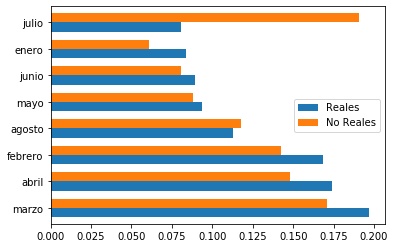

In [108]:
plot_barh(df_real, 'Reales', df_non_real, 'No Reales', 'MES')

In [15]:
def filter_month(month):
    return df[df['MES']==month]    

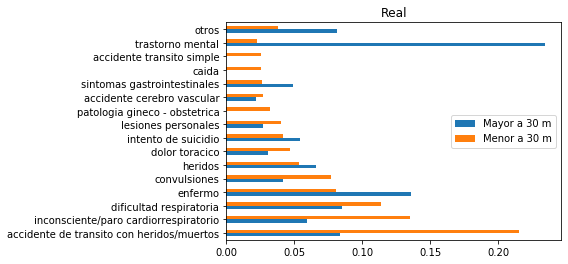

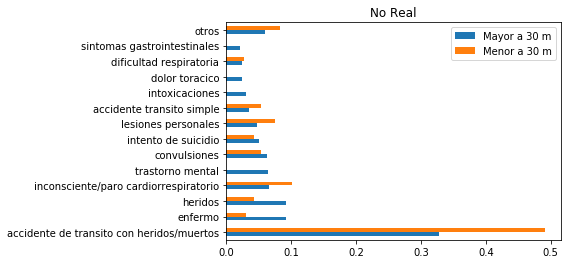

In [115]:
#fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)

#ax.invert_xaxis()
#ax.yaxis.tick_right()

df1=plot_barh(df_real.loc[df_real['DELTA_TIEMPO']>30.0], 'Mayor a 30 m', df_real.loc[df_real['DELTA_TIEMPO']<=30.0], 'Menor a 30 m','TIPO_INCIDENTE')
df2=plot_barh(df_non_real.loc[df_non_real['DELTA_TIEMPO']>30.0], 'Mayor a 30 m', df_non_real.loc[df_non_real['DELTA_TIEMPO']<=30.0], 'Menor a 30 m','TIPO_INCIDENTE')

df1.plot(kind='barh',title='Real')
df2.plot(kind='barh', title='No Real')
plt.show()

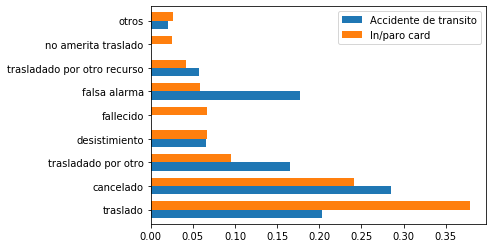

In [117]:
plot_barh(df.loc[df['TIPO_INCIDENTE']=='accidente de transito con heridos/muertos'], 'Accidente de transito', df.loc[df['TIPO_INCIDENTE']=='inconsciente/paro cardiorrespiratorio'], 'In/paro card','CLASIFICACION FINAL')

In [86]:
df.loc[(df['DELTA_TIEMPO']>30.0) & (df['DELTA_TIEMPO']<100.0)]['DELTA_TIEMPO'].sum()

797366.0

In [84]:
df.loc[df['DELTA_TIEMPO']<30.0]['DELTA_TIEMPO'].sum()

861446.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85afd7f588>]],
      dtype=object)

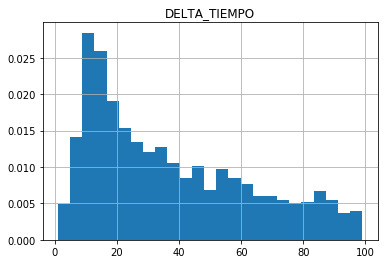

In [105]:
df_transi=df.loc[df['TIPO_INCIDENTE']=='accidente de transito con heridos/muertos']
df_transi.loc[df_transi['DELTA_TIEMPO']<100].hist('DELTA_TIEMPO', bins=25,density=True)

In [68]:
#heatmap
df_hm=df[~ (df['MES']=='agosto')]

In [69]:
df_hm['timeStamp']=pd.to_datetime(df_hm['FECHA_INCIDENTE'].transform(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y %H:%M') ))

/home/nicolasbb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
df_hm['Hour']=df_hm['timeStamp'].apply(lambda x:x.hour)
df_hm['Month']=df_hm['timeStamp'].apply(lambda x:x.month)
df_hm['DayOfWeek']=df_hm['timeStamp'].apply(lambda x:x.dayofweek)

/home/nicolasbb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/nicolasbb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nicolasbb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [71]:
dmap={0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}

In [72]:
mmap={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

In [73]:
df_hm['Month']=df_hm['Month'].map(mmap)
df_hm['DayOfWeek']=df_hm['DayOfWeek'].map(dmap)

/home/nicolasbb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/nicolasbb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [359]:
dayHour=df_hm.loc[ df_hm['TIPO_INCIDENTE'].isin(['intento de suicidio'])].groupby(by=['DayOfWeek','Hour']).count()['MES'].unstack()

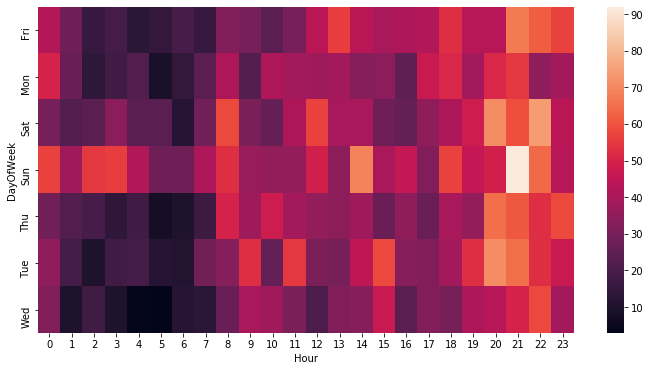

In [360]:
import seaborn as sns



plt.figure(figsize=(12,6))
sns.heatmap(dayHour)

# Analitica de datos

## Deteccion de outliers

In [118]:
import scipy
import scipy.stats as ss
import numpy as np

In [229]:
df_transi=df_hm.loc[df_hm['TIPO_INCIDENTE']=='trastorno mental']
x=df_transi['DELTA_TIEMPO'].values
y=np.isfinite(x)
fit2 = ss.genpareto.fit(x[y])
print(fit2)

/home/nicolasbb/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/nicolasbb/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/nicolasbb/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(0.21508982674203247, 0.9999996662771748, 66.50112690138593)


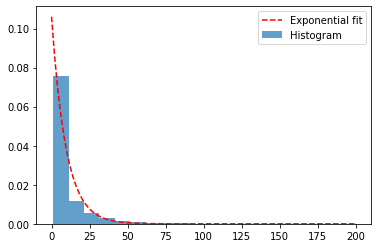

In [215]:
plt.hist(df_transi.loc[(df_transi['DELTA_TIEMPO']<200.0)]['DELTA_TIEMPO'], bins=18, density=True, alpha=0.7, label='Histogram')
plt.plot(np.linspace(0, 200, 100),
         ss.expon.pdf(np.linspace(1, 200, 100), fit2[0], fit2[1]), 'r--',
         label='Exponential fit')
plt.legend(loc='upper right')
plt.show()

In [218]:
boundary = ss.expon.ppf(0.85, fit2[0], fit2[1])
print(f'The one precent threshold for call duration {boundary:6.4f}')

The one precent threshold for call duration 18.8859


In [179]:
prob_over_60 = (ss.genpareto.cdf(60, fit2[0], fit2[1], fit2[2]))
print('{:.2f}'.format(prob_over_60))

0.56


## Comparacion de outliers

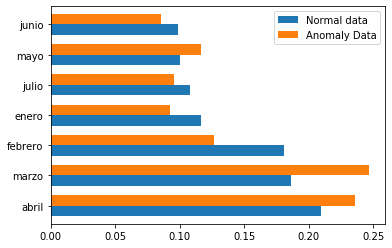

In [232]:
plot_barh(df_transi.loc[(df_transi['DELTA_TIEMPO']<156)], 'Normal data', df_transi.loc[(df_transi['DELTA_TIEMPO']>156) & (df['DELTA_TIEMPO']<280)], 'Anomaly Data','MES')

In [225]:
len(df_transi.loc[(df_transi['DELTA_TIEMPO']>19) & (df['DELTA_TIEMPO']<29)])/len(df_transi)

0.05591194968553459

In [226]:
df_transi.loc[(df_transi['DELTA_TIEMPO']>19) & (df['DELTA_TIEMPO']<29)]['DELTA_TIEMPO'].sum()/df_transi['DELTA_TIEMPO'].sum()

0.13064951455097526